# Cross validation

## I) Imports

In [2]:
from proj1_helpers import *
from custom_helpers import *
from plot import *
from implementations import *
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2

## II) Required functions

In [3]:
def build_k_indices(y, k_fold, seed):
    """build k indices for k-fold."""
    num_row = y.shape[0]
    interval = int(num_row / k_fold)
    np.random.seed(seed)
    indices = np.random.permutation(num_row)
    k_indices = [indices[k * interval: (k + 1) * interval]
                 for k in range(k_fold)]
    return np.array(k_indices)

In [10]:
def cross_validation(x, y, flag_method, degree, lambda_=0, gamma=1.e-6, max_iters=1000, k_fold=int(5), seed=143225):
    "Train the model and evaluate loss based on cross validation"
    mses_tr = []
    mses_te = []
    accuracy_tr = []
    accuracy_te = []
    
    flag_add_offset = True
    flag_standardize = True
    flag_remove_outliers = False
    
    k_indices = build_k_indices(y, k_fold, seed);
    for i in range(k_fold):
        newk_index = np.delete(k_indices, i, 0)
        indices_train = newk_index.ravel()
        indices_test = k_indices[i]

        # Train data at each iteration "i" of the loop
        x_train = x[indices_train]
        y_train = y[indices_train]

        # Validate the data at each iteration "i" of the loop
        x_test = x[indices_test]
        y_test = y[indices_test]

        # Prepare data (Standardisation and offset)
        training_tx, testing_tx = prepare_data(x_train, x_test, flag_add_offset, flag_standardize, flag_remove_outliers, degree)
        
        # create initial w for methods using it
        initial_w = np.zeros(training_tx.shape[1])

        if flag_method == 0:
            # Use linear regression (full gradient descent)
            weight, _ = least_squares_GD(y_train, training_tx, initial_w, max_iters, gamma)
            
        if flag_method == 1:
            # Use linear regression (stochastic gradient descent)
            weight, _ = least_squares_SGD(y_train, training_tx, initial_w, max_iters, gamma)
            
        if flag_method == 2:
            # Use least squares method
            weight, _ = least_squares(y_train, training_tx)
            
        if flag_method == 3:
            # Use ridge regression
            weight, _ = ridge_regression(y_train, training_tx, lambda_)
            
        if flag_method == 4:
            # Use logistic regression
            weight, _ = logistic_regression(y_train, training_tx, initial_w, max_iters, gamma)
            
        if flag_method == 5:
            # Use regularized logistic regression
            weight, _ = reg_logistic_regression(y_train, training_tx, initial_w, max_iters, gamma, lambda_)
            
        loss_te = np.sqrt(2 * compute_mse(y_test, testing_tx, weight))
        loss_tr = np.sqrt(2 * compute_mse(y_train, training_tx, weight))
        
        # Append loss of this round to list
        mses_tr.append(loss_tr)
        mses_te.append(loss_te)
        
        # calculate accuracy and add it to list
        y_pred_tr = predict_labels(weight, training_tx)
        y_pred_te = predict_labels(weight, testing_tx)
        accuracy_tr.append(np.sum(y_pred_tr == y_train)/len(y_train))
        accuracy_te.append(np.sum(y_pred_te == y_test)/len(y_test))


    mean_accuracy_tr = np.mean(accuracy_tr)
    mean_accuracy_te = np.mean(accuracy_te)
    loss_tr = np.mean(mses_tr)
    loss_te = np.mean(mses_te)
    return loss_tr, loss_te, mean_accuracy_tr, mean_accuracy_te

## III) Main
### Load the data

In [5]:
# Loading Data
print("Loading Data, please wait")
train_y, train_x, ids_train = load_csv_data('data/train.csv')
print("Data loaded, continue!!")

Loading Data, please wait
Data loaded, continue!!


In [6]:
"""
Methods mapping
0    Linear regression (full gradient descent)
1    Linear regression (stochastic gradient descent)
2    Least squares method
3    Ridge regression
4    Logistic regression (stochastic gradient descent)
5    Regularized logistic regression (stochastic gradient descent)

"""

'\nMethods mapping\n0    Linear regression (full gradient descent)\n1    Linear regression (stochastic gradient descent)\n2    Least squares method\n3    Ridge regression\n4    Logistic regression (stochastic gradient descent)\n5    Regularized logistic regression (stochastic gradient descent)\n\n'

### Cross validation for one set of parameters only
Get the RMSE for one method with defined parameters

In [7]:
# Chose learnig method to use (see mapping above)
flag_method = 2;
degree = 2
lambda_ = 0.001

# set Gradient descent parameters
gamma = 0.01
max_iters = 20

# Preparing data for cross validation
ytrain_cross_validation = train_y.copy()
xtrain=remove_invalid(train_x)

_, loss_te, _, accuracy_te = cross_validation(xtrain, ytrain_cross_validation, flag_method, degree, lambda_, gamma, max_iters)
print("For the Degree: %d cross-validation loss is %f, and accuracy is %f" %(degree, loss_te, accuracy_te))

KeyboardInterrupt: 

### Grid search for methods without regularisation
Test polynominal expansion of different degrees

In [ ]:
# Chose learnig method to use (see mapping above)
flag_method = 4;

# set Gradient descent parameters
gamma = 0.1
max_iters = 1000

# Define range for the polynomial expansion
degree_range = np.arange(1, 3)

train_losses = np.zeros(len(degree_range))
test_losses = np.zeros(len(degree_range))
train_accuracies = np.zeros(len(degree_range))
test_accuracies = np.zeros(len(degree_range))

# Preparing data for cross validation
ytrain_cross_validation = train_y.copy()
xtrain=remove_invalid(train_x)

for ind_degree, degree in enumerate(degree_range):
    loss_tr, loss_te , accuracy_tr, accuracy_te= cross_validation(xtrain, ytrain_cross_validation, flag_method, degree, 0, gamma, max_iters)
    print("For the Degree: %d , The LOSS is : %f" %(degree, loss_te))
    train_losses[ind_degree] = loss_tr
    test_losses[ind_degree] = loss_te
    test_accuracies[ind_degree] = accuracy_tr
    test_accuracies[ind_degree] = accuracy_te
    
print("Cross Validation finished!!")
best_value = np.unravel_index(np.argmin(test_losses), test_losses.shape)
print("The best degrees are: ", degree_range[best_value])

In [ ]:
# Visualize
print("Test accuracy:")
print(test_accuracies)
cross_validation_visualization_degree(degree_range, train_losses, test_losses)

### Grid search for Methods using regularisation
Grid search over different degrees of polynominal expansion and for different lambdas

In [16]:
# Chose learnig method to use (see mapping above)
flag_method = 5;

# set Gradient descent parameters
gamma = 0.1
max_iters = 500

# Define range for the polynomial expansion and for lambda
degree_range = np.arange(1, 2)
lambda_range = np.arange(0, 1000, 300)

train_losses_matrix = np.zeros((len(degree_range), len(lambda_range)))
test_losses_matrix = np.zeros((len(degree_range), len(lambda_range)))
train_accuracies_matrix = np.zeros((len(degree_range), len(lambda_range)))
test_accuracies_matrix = np.zeros((len(degree_range), len(lambda_range)))

# Preparing data for cross validation
ytrain_cross_validation = train_y.copy()
xtrain = remove_invalid(train_x)

for ind_degree, degree in enumerate(degree_range):
    for ind_lambda_, lambda_ in enumerate(lambda_range):
        loss_tr, loss_te , accuracy_tr, accuracy_te= cross_validation(xtrain, ytrain_cross_validation, flag_method, degree, lambda_, gamma, max_iters)
        print("For the Degree: %d and lambda %.2E, The LOSS is : %f" %(degree, lambda_, loss_te))
        train_losses_matrix[ind_degree, ind_lambda_] = loss_tr
        test_losses_matrix[ind_degree, ind_lambda_] = loss_te
        train_accuracies_matrix[ind_degree, ind_lambda_] = accuracy_tr
        test_accuracies_matrix[ind_degree, ind_lambda_] = accuracy_te

print("Cross Validation finished!!")
best_value = np.unravel_index(np.argmin(test_losses_matrix), test_losses_matrix.shape)
print(best_value)
print("Best degree: %d, with lambda %f " %(degree_range[best_value[0]], lambda_range[best_value[1]]))

iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  0.6244300482999456
iteration	 100 	loss:  0.5947400919348644
iteration	 150 	loss:  0.5820373274626097
iteration	 200 	loss:  0.5728809514233614
iteration	 250 	loss:  0.5658750402261199
iteration	 300 	loss:  0.5604126331420326
iteration	 350 	loss:  0.5560955680418571
iteration	 400 	loss:  0.552643123927952
iteration	 450 	loss:  0.54985257884781
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  0.6245079087298614
iteration	 100 	loss:  0.5950044158532545
iteration	 150 	loss:  0.5824356514361658
iteration	 200 	loss:  0.5733888099619017
iteration	 250 	loss:  0.566475757295157
iteration	 300 	loss:  0.5610924159225454
iteration	 350 	loss:  0.556842633195852
iteration	 400 	loss:  0.5534473917493695
iteration	 450 	loss:  0.5507054623527218
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  0.6247309791715705
iteration	 100 	loss:  0.5953271991580401
iteration	 150 	loss:  0.5828083152621322


iteration	 100 	loss:  0.5966011916342429
iteration	 150 	loss:  0.5841850624673914
iteration	 200 	loss:  0.5756391721763219
iteration	 250 	loss:  0.5694458306292465
iteration	 300 	loss:  0.5649032472991616
iteration	 350 	loss:  0.5615519725071738
iteration	 400 	loss:  0.5590697958578755
iteration	 450 	loss:  0.5572270620886409
For the Degree: 1 and lambda 9.00E+02, The LOSS is : 1.050647
Cross Validation finished!!
(0, 1)
Best degree: 1, with lambda 300.000000 


Test accuracy:
[[0.707696 0.70772  0.70772  0.707636]]


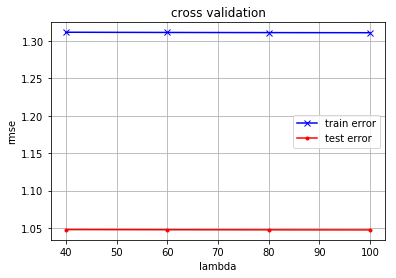

In [15]:
# Visualize
print("Test accuracy:")
print(test_accuracies_matrix)
cross_validation_visualization_lambda(lambda_range, train_losses_matrix[0, :], test_losses_matrix[0, :])